This notebook shows a short demonstration of using data from HIP partners to do simulation, with parameters guessed from one of the patient's seizures.

In [1]:
%pylab inline
import re
import numpy as np
import mne
import nibabel
from tvb.simulator.lab import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


Let's check our access to some data

First sEEG contacts: use your favorite 3D tool to localize sEEG contacts in T1 space as in the following example:

In [3]:
!head ~/nextcloud/tvb-preprocessed-tutorial-data/fs/hip1/elec/seeg.xyz

L1      -12.20   53.60   67.20
L2       -8.70   53.65   67.20
L3       -5.20   53.69   67.20
L4       -1.70   53.74   67.20
L5        1.80   53.78   67.20
L6        5.30   53.83   67.20
L7        8.80   53.88   67.20
L8       12.30   53.92   67.20
L9       15.80   53.97   67.20
L10      19.30   54.02   67.20


then we load them

In [4]:
pl_names = []
pl_xyz = []
fsdir = os.path.expanduser('~/nextcloud/tvb-preprocessed-tutorial-data/fs/hip1')
with open(f'{fsdir}/elec/seeg.xyz', 'r') as fd:
    for line in fd.readlines():
        if line.startswith('plot'):
            continue
        name, *xyz = [_ for _ in line.strip().split(' ') if _.strip()]
        pl_names.append(name)
        pl_xyz.append(np.array([float(_) for _ in xyz]))

Load connectivity & one seizure,

2023-09-12 13:37:58,933 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


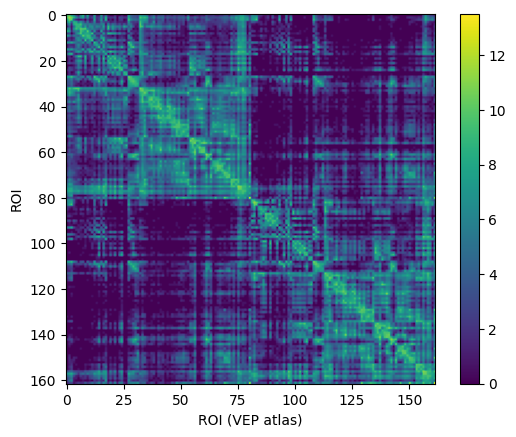

In [5]:
conn = connectivity.Connectivity.from_file(f'{fsdir}/tvb/connectivity.vep.zip')
conn.configure()
conn.weights[:] = np.log(1 + conn.weights)
imshow(conn.weights); colorbar(); xlabel('ROI (VEP atlas)'), ylabel('ROI'); show();

If seizure is not in VHDR, convert first with Anywave:

In [8]:
!ls ~/nextcloud/tutorial_data/Data_for_electrodes_labelling/Case1/SEEG

case1EEG_12HIP_RAS.TRC		    case1EEG_13HIP_seizure.TRC.mrk
case1EEG_13HIP_seizure.TRC	    case1EEG_13HIP_seizure.TRC.mtg
case1EEG_13HIP_seizure.TRC.bad	    case1EEG_14HIP_seizure.TRC
case1EEG_13HIP_seizure.TRC.display


We open the TRC w/ Anywave, mark bad channels, isolate the section with the seizure with a marker for that section, 
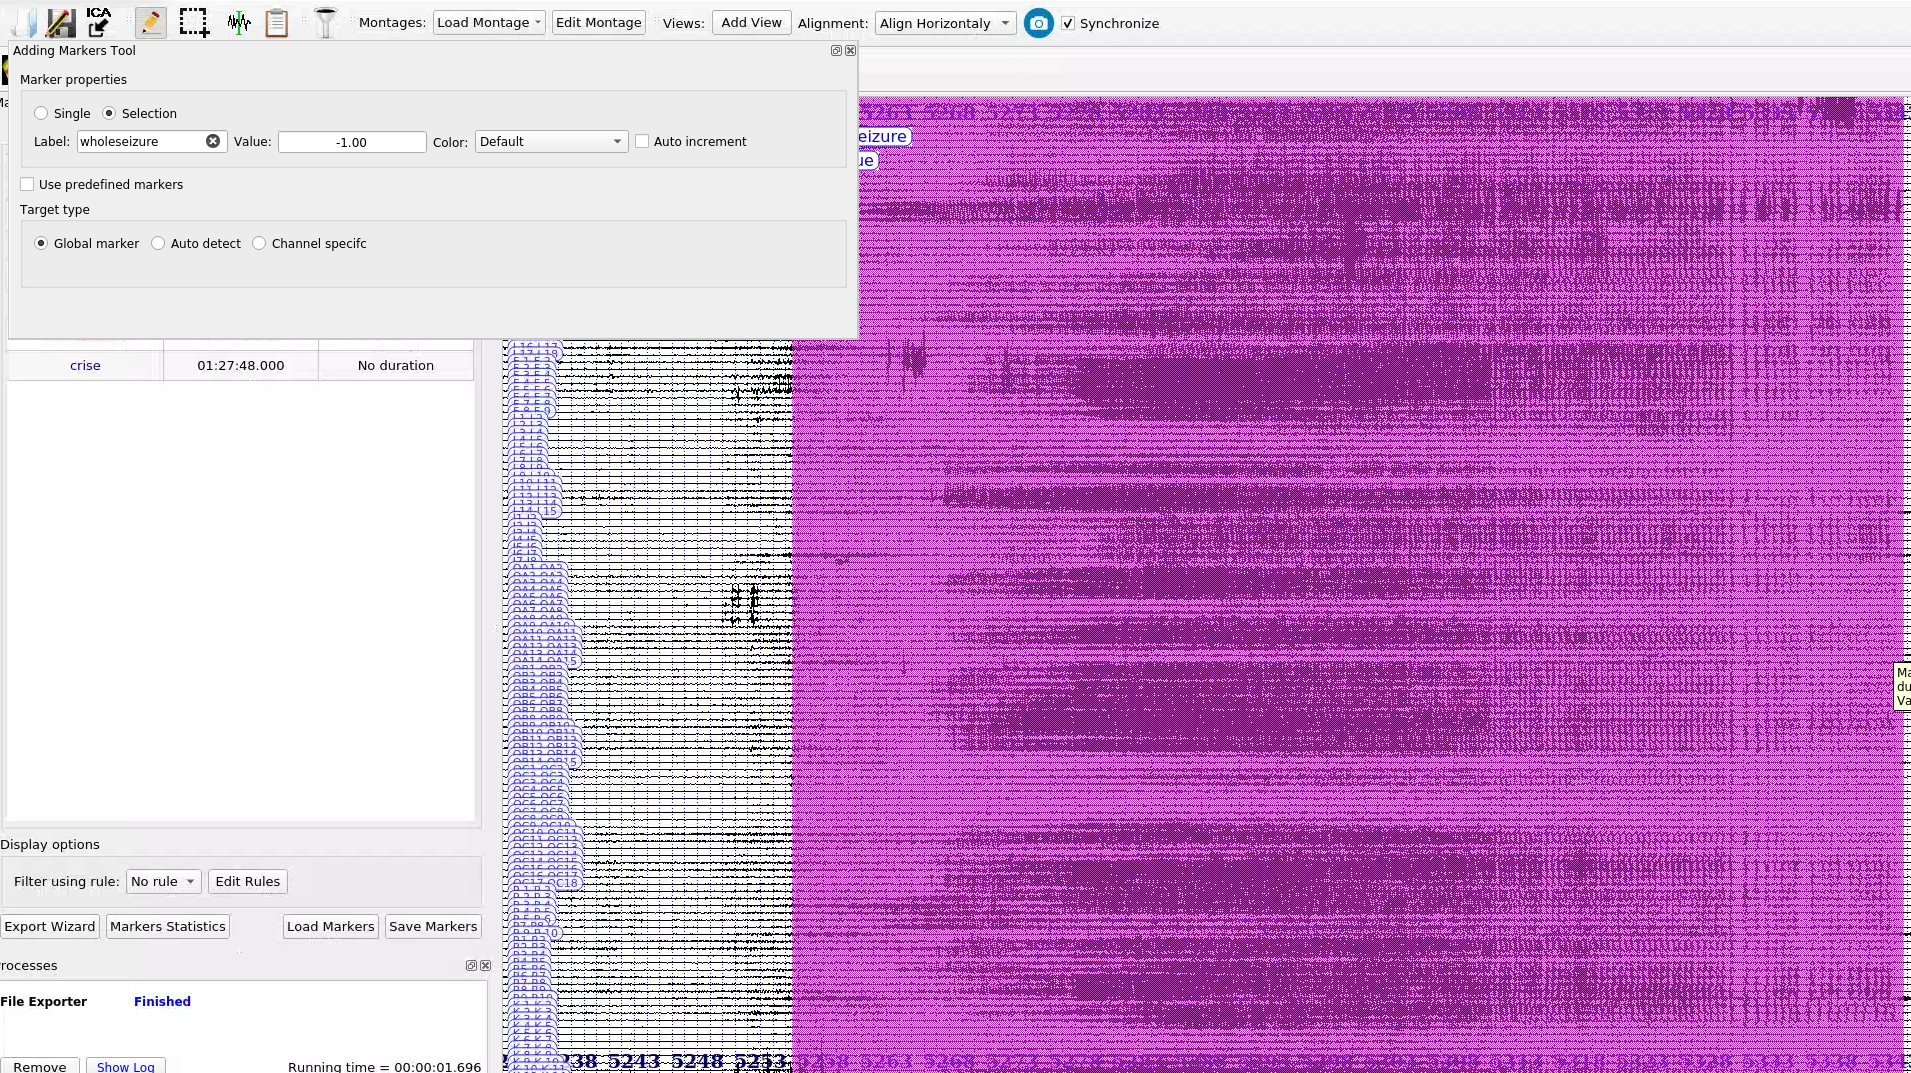

start an export

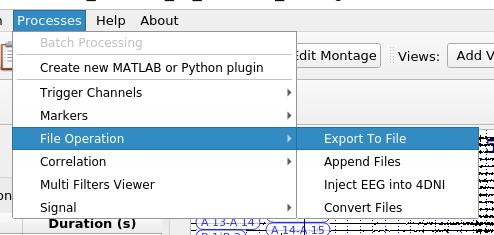

set file name w/ marker name

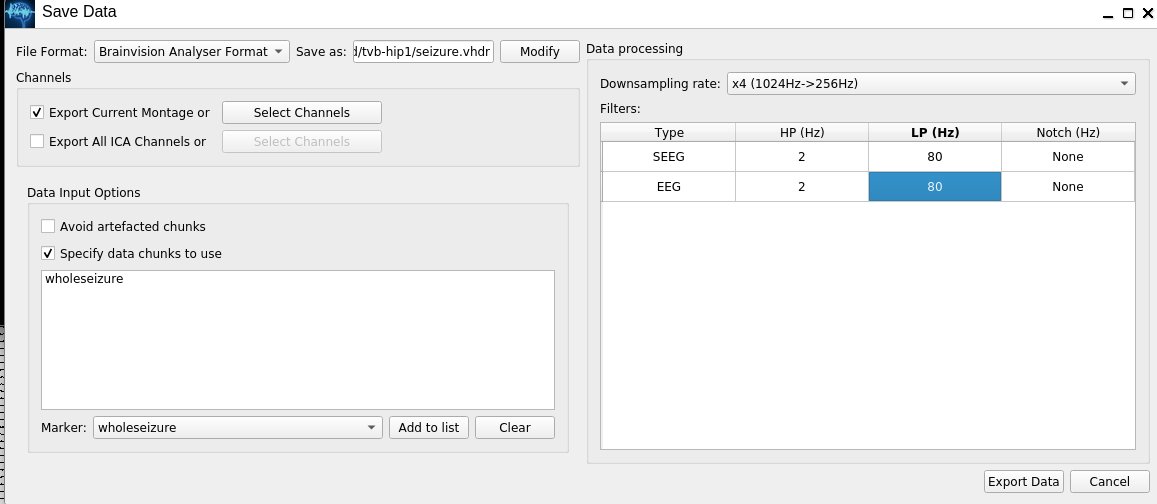

and save to the tvb folder, then load with MNE:

In [6]:
!ls ~/nextcloud/tvb-preprocessed-tutorial-data/fs/hip1/seeg/tvb-hip1

seizure-bipolar.eeg   seizure-monopolar.eeg   seizure.eeg
seizure-bipolar.vhdr  seizure-monopolar.vhdr  seizure.vhdr
seizure-bipolar.vmrk  seizure-monopolar.vmrk  seizure.vmrk


In [9]:
raw = mne.io.read_raw_brainvision(
    f'{fsdir}/seeg/tvb-hip1/seizure-bipolar.vhdr',
    preload=True
)

Extracting parameters from /home/woodman/nextcloud/tvb-preprocessed-tutorial-data/fs/hip1/seeg/tvb-hip1/seizure-bipolar.vhdr...
Setting channel info structure...
Reading 0 ... 25378  =      0.000 ...    99.133 secs...


/tmp/ipykernel_421/3985157263.py:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_brainvision(


Construct gain matrix for bipolar electrodes in recording,

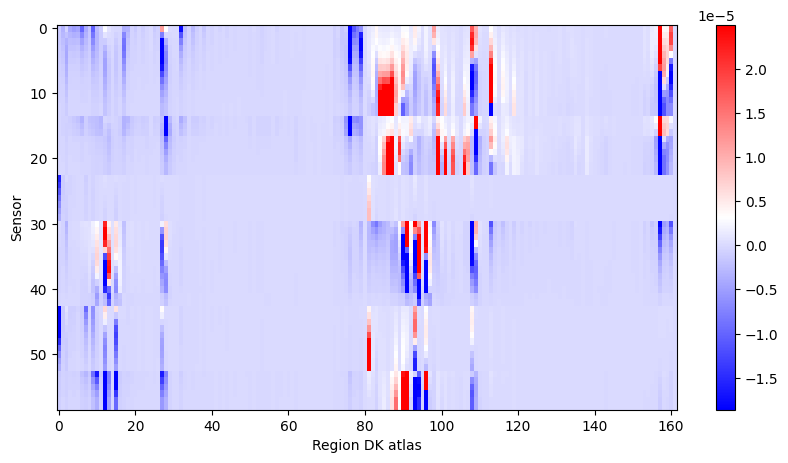

In [10]:
re_one = '([A-Z][A-Za-z]*\'?) ([0-9]+)'
re_bip = re.compile(f'{re_one}-{re_one}')
ch_bip_idx = []
bip_gain = []
electrodes = []
picks = []
pick_names = []
for i_ch, ch in enumerate(raw.ch_names):
    match = re_bip.match(ch)
    if match:
        picks.append(i_ch)
        pick_names.append(ch)
        e, i, _, j = match.groups()
        electrodes.append(e)
        i, j = int(i), int(j)
        e = e.replace('\'', 'p')
        ch_bip_idx.append((e, i, j))
        #pl_names.index(
        #r = np.sqrt(np.sum((cxyz(e,np.c_[i,j].T)[:,None] - conn.centres)**2, axis=2))
        try:
            cxyz = np.c_[pl_xyz[pl_names.index(f'{e}{i}')],
                         pl_xyz[pl_names.index(f'{e}{j}')]].T[:, None]
        except ValueError:
            pass
        r = np.sqrt(np.sum((cxyz - conn.centres)**2, axis=2))    
        g = 1/r**3
        bip_gain.append(g[1] - g[0])
picks = np.array(picks)
bip_gain = np.array(bip_gain)
bip_gain = np.clip(bip_gain, *np.percentile(bip_gain.flat[:], [1,99]))
figure(figsize=(10, 5))
imshow(bip_gain, cmap='bwr', aspect='auto', interpolation='none'), colorbar(), xlabel('Region DK atlas'), ylabel('Sensor');

Pick out seizure from recording,

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Using matplotlib as 2D backend.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


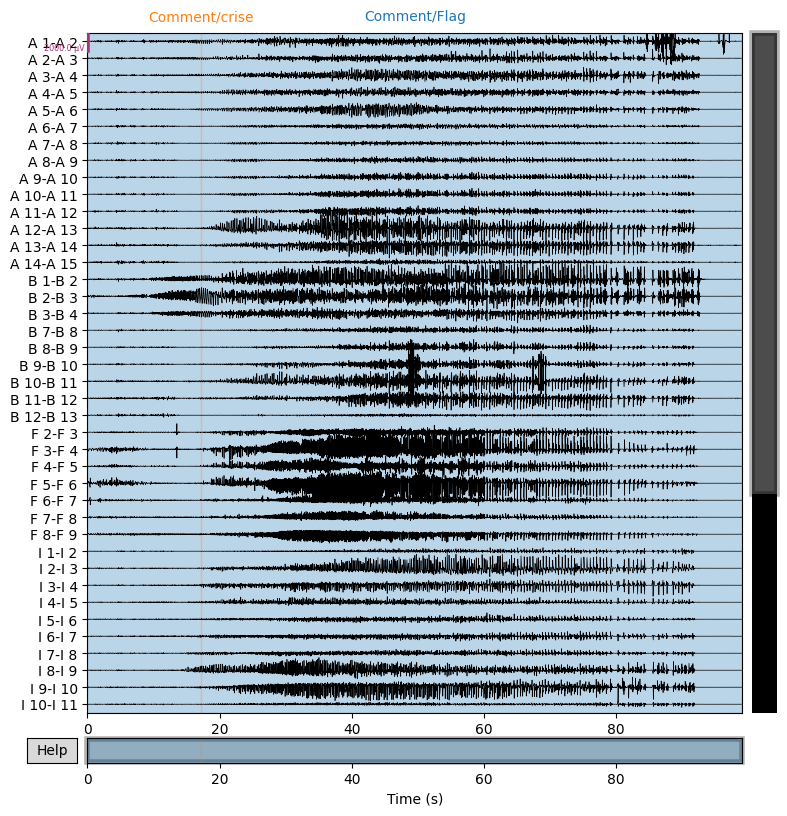

In [11]:
snip = raw.copy()
snip.pick_channels(pick_names)
snip.load_data()
snip.filter(1,30)
snip.resample(64)
snip.plot(n_channels=40,duration=100,scalings={'eeg':1e-3});

We construct the envelop of the data, per 1 s windows,

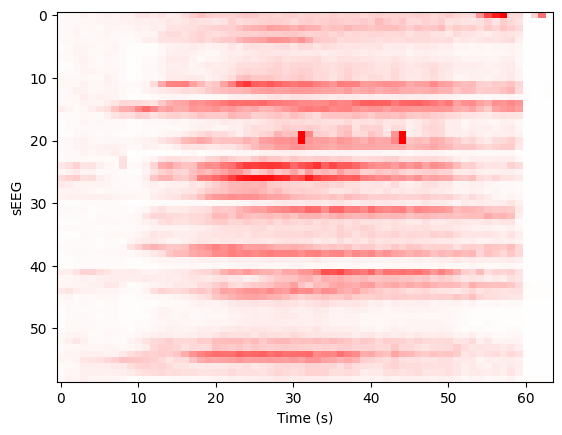

In [12]:
y, t = snip[:]
ysd = y[:,:y.shape[1]//64*64].reshape((len(y), 64, -1)).std(axis=-1)
scl = 1e-3
imshow(ysd, aspect='auto', interpolation='none', cmap='bwr', vmin=-scl, vmax=scl)
xlabel('Time (s)'), ylabel('sEEG'); show();

Projecting to TVB sources, we can determine a prior for the Epileptor x0 parameter based onset times,

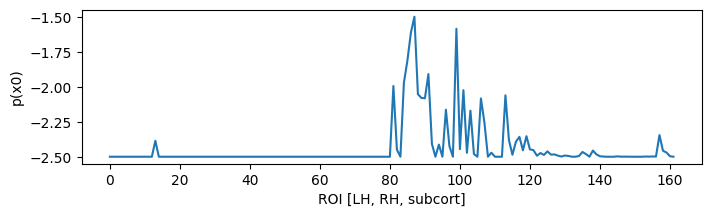

In [13]:
ssd = np.clip(bip_gain.T.dot(ysd),0,1) * np.r_[1:0:64j]**3
x0p = ssd.sum(axis=-1)
x0p /= x0p.max()
x0p = -2.5 + x0p
figure(figsize=(8, 2)); plot(x0p); xlabel('ROI [LH, RH, subcort]'); ylabel('p(x0)'); show();

With a few examples for the ranking

In [14]:
for i in np.argsort(x0p)[::-1][:5]:
    print(i, x0p[i], conn.region_labels[i])

87 -1.5 Right-Inferior-frontal-sulcus
99 -1.5861556255555924 Right-Precentral-sulcus-inferior-part
86 -1.6136127237070008 Right-F3-pars-opercularis
85 -1.8120990493471199 Right-F3-Pars-triangularis
91 -1.9098045348007213 Right-SFS-rostral


Now construct a simulation,

In [15]:
epileptor = models.Epileptor(Ks=np.r_[-0.2], Kf=np.r_[0.1], r=np.r_[0.00015])
epileptor.x0 = x0p
nsig = np.r_[0., 0., 0., 0.0005, 0.0005, 0.]
addnoise = noise.Additive(nsig=nsig, ntau=5.0)
initial = np.r_[-1.9, -17., 3.1, -1., 0.04, -0.17]
initial = np.zeros((100, 1, conn.number_of_regions, 1)) + initial[:, None, None]
sim = simulator.Simulator(
    connectivity=conn,
    coupling=coupling.Difference(a=np.r_[0.03]),
    model=epileptor,
    integrator=integrators.HeunStochastic(dt=0.05,noise=addnoise),
    initial_conditions=initial,
)
sim.configure()

Run the simulation

In [16]:
(t,y), = sim.run(simulation_length=4000.0)
y += randn(*y.shape)/10 # observation noise

Butterfly plot of source activity for seizure,

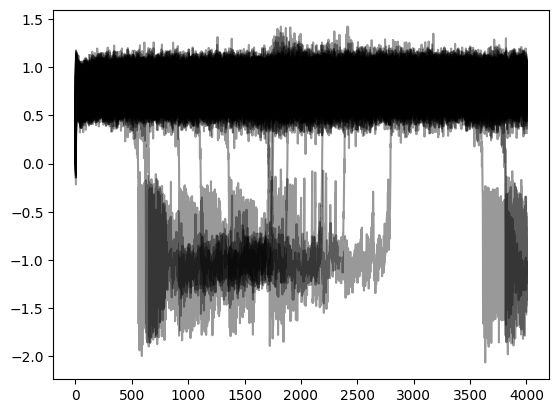

In [17]:
plot(t,y[:,0,:,0], 'k', alpha=0.4); show();

Projecting the source activity back to sources and creating an MNE Raw object from that, for analysis

In [18]:
seeg = bip_gain.dot(y[:,0,:,0].T)
seeg /= seeg.std()
seeg *= snip[:][0].std()
info = mne.create_info(pick_names, 1e3/(t[1] - t[0])/8, 'eeg')
raw_sim = mne.io.RawArray(seeg, info)
raw_sim.info['sfreq']

Creating RawArray with float64 data, n_channels=59, n_times=4000
    Range : 0 ... 3999 =      0.000 ...    31.992 secs
Ready.


125.0

then filter and inspect seizure,

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 413 samples (3.304 s)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  59 out of  59 | elapsed:    0.8s finished


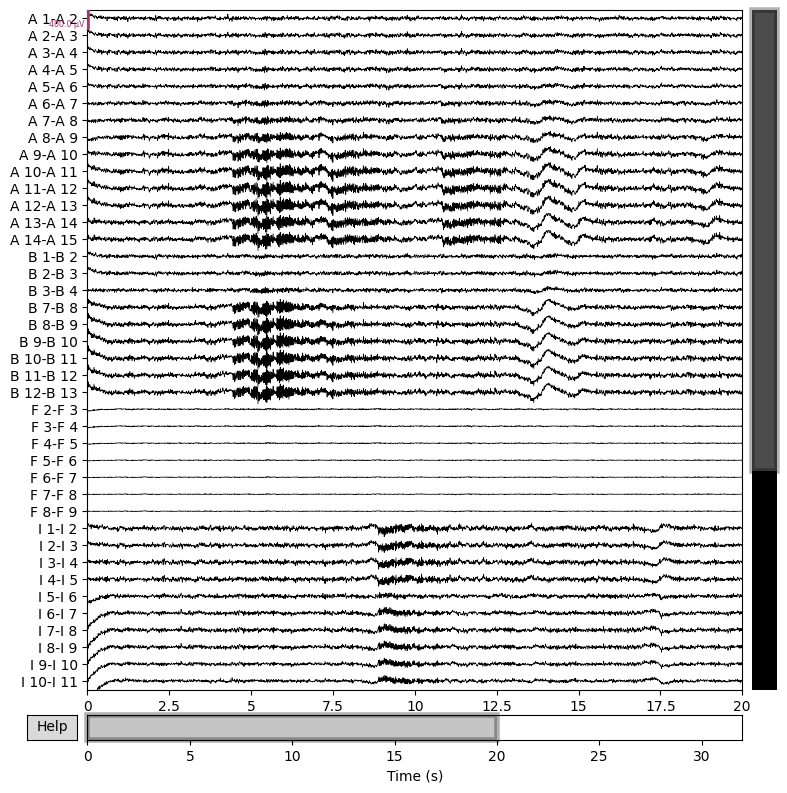

In [19]:
raw_sim.filter(1,50,n_jobs=4)
raw_sim.plot(n_channels=40,duration=20,scalings={'eeg':2e-4});

This shows that we can quickly reproduce a seizure similar the patient's with a TVB model, with an seizure onset heuristic.  For a more precise match, the `x0` parameter of the model requires some tuning.  This can be done by hand or automatically, via Bayesian inference, which will be the subject of another workflow example.